#Camera Calibration using DLT## 

In [ ]:
#mounting gDrive 
from google.colab import drive
!gdown https://drive.google.com/uc?id=1n2mY6SXWgH_Ll92jZhdEfEPH5wvj36oC&export=download
!gdown https://drive.google.com/uc?id=1itPyrwDRKwssvzBJ6OVWyNMVH5TH1giy&export=download

Downloading...
From: https://drive.google.com/uc?id=1n2mY6SXWgH_Ll92jZhdEfEPH5wvj36oC
To: /content/data.xlsx
100% 9.06k/9.06k [00:00<00:00, 15.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1itPyrwDRKwssvzBJ6OVWyNMVH5TH1giy
To: /content/IMG1.jpg
100% 1.27M/1.27M [00:00<00:00, 81.9MB/s]


In [ ]:
from PIL import Image
import numpy as np
import pandas as pd

## Visulalize Data

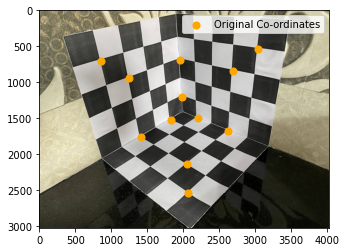

   X  Y  Z     x     y
0  1  0  0  1831  1524
1  3  0  0  1408  1765
2  0  1  0  2200  1499
3  0  3  0  2627  1671
4  0  0  1  1988  1204


In [ ]:
import matplotlib.pyplot as plt
image=Image.open('/content/IMG1.jpg')
data=pd.read_excel('/content/data.xlsx')
pic=np.asarray(image)
plt.imshow(image)

data_np=np.array(data)
world_coord=data_np[:,:3]
cam_coord=data_np[:,3:]

plt.scatter(cam_coord[:,0], cam_coord[:,1], marker=r'o', s=50, label='Original Co-ordinates', c='orange')
plt.legend()
plt.savefig('plot_original.png',dpi=400,bbox_inches='tight')
plt.show()
print(data.head())

## Here comes the Math

In [ ]:
world_coord_homo=np.concatenate((world_coord,np.ones((world_coord.shape[0],1))),axis=1)
cam_coord_homo=np.concatenate((cam_coord,np.ones((cam_coord.shape[0],1))),axis=1)

In [ ]:
world_centroid=(np.sum(world_coord,axis=0)/world_coord.shape[0]).reshape(1,3)
cam_centroid=(np.sum(cam_coord, axis=0)/cam_coord.shape[0]).reshape(1,2)

world_avg_dist=np.sum(np.sqrt(np.sum((world_coord-world_centroid)**2,axis=1)),axis=0)
cam_avg_dist=np.sum(np.sqrt(np.sum((cam_coord-cam_centroid)**2,axis=1)),axis=0)

U=np.concatenate((np.eye(3),-1*world_centroid.T),axis=1)*(np.sqrt(3)/world_avg_dist)
T=np.concatenate((np.eye(2),-1*cam_centroid.T),axis=1)*(np.sqrt(2)/cam_avg_dist)

In [ ]:
U_homo=np.concatenate((U,np.zeros((1,U.shape[1]))),axis=0)
U_homo[-1,-1]=1
T_homo=np.concatenate((T,np.zeros((1,T.shape[1]))),axis=0)
T_homo[-1,-1]=1

world_N=np.dot(U,world_coord_homo.T).T
cam_N=np.dot(T,cam_coord_homo.T).T

world_homo_N=np.concatenate((world_N,np.ones((world_N.shape[0],1))),axis=1)
cam_homo_N=np.concatenate((cam_N,np.ones((cam_N.shape[0],1))),axis=1)

In [ ]:
P=np.ones((1,12))
for i in range(world_coord.shape[0]):
    temp1=np.concatenate((world_homo_N[i,:].T.reshape(1,4),np.zeros((1,4))),axis=1)
    temp1=np.concatenate((temp1,-1*cam_homo_N[i,0]*world_homo_N[i,:].T.reshape(1,4)),axis=1)
    
    temp2=np.concatenate((np.zeros((1,4)),world_homo_N[i,:].T.reshape(1,4)),axis=1)
    temp2=np.concatenate((temp2,-1*cam_homo_N[i,1]*world_homo_N[i,:].T.reshape(1,4)),axis=1)
    
    P=np.concatenate((P,temp1),axis=0)
    P=np.concatenate((P,temp2),axis=0)
P=P[1:,:]

eig_val, eig_vec= np.linalg.eig(np.dot(P.T,P))
index=np.argmin(eig_val)

In [ ]:
M_normalized=eig_vec[:,index].reshape(3,4)
rho=1/np.linalg.norm(M_normalized[2,:3])
M_normalized=M_normalized*rho
M=np.dot(np.linalg.inv(T_homo),np.dot(M_normalized,U_homo))

In [ ]:
result=np.dot(M,world_coord_homo.T).T
Z=np.dot(M[2,:],world_coord_homo.T).T
result=result*(1/Z.reshape(12,1))

## Visualize predictions

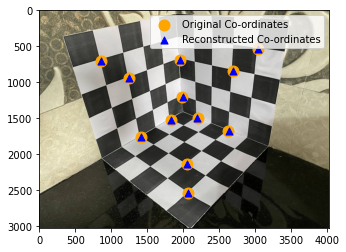

In [ ]:
plt.imshow(image)
plt.scatter(cam_coord[:,0], cam_coord[:,1], marker=r'o', s=120, label='Original Co-ordinates', c='orange')
plt.scatter(result[:,0], result[:,1],  marker='^', s=50, label='Reconstructed Co-ordinates', c='b')
plt.legend()
plt.savefig('plot_projection.png',dpi=400,bbox_inches='tight')
plt.show()

In [ ]:
print("Camera Co-ordinates")
print(cam_coord)
print("")
print("Reconstructed Co-ordinates")
print(np.round(result[:,:-1]))
print("")
from sklearn.metrics import mean_squared_error as mse
print("MSE in pixel units")
print(mse(result[:,:-1], cam_coord))

Camera Co-ordinates
[[1831 1524]
 [1408 1765]
 [2200 1499]
 [2627 1671]
 [1988 1204]
 [1955  688]
 [2050 2142]
 [1247  946]
 [2686  836]
 [2072 2536]
 [ 861  699]
 [3042  537]]

Reconstructed Co-ordinates
[[1827. 1525.]
 [1411. 1767.]
 [2193. 1497.]
 [2633. 1673.]
 [1990. 1200.]
 [1957.  690.]
 [2048. 2141.]
 [1251.  947.]
 [2685.  839.]
 [2072. 2534.]
 [ 856.  698.]
 [3040.  535.]]

MSE in pixel units
9.607188898974437


## Obtaining K, [R, T] by rq decomposition of Projection Matrix

In [ ]:
from scipy.linalg import rq
import numpy as np
print("Obtained projection Matrix : ")
print(M)
print("")
A=M[:, :-1]
b=M[:, -1]
K, R= rq(A, mode='full')
elem = K[2,2]
# Bringing K to standard form 
K=K/elem
print("Intrinsic Param Matrix : ")
print(np.round(K))
print("")
# Homogenizing the R and T Matrices
print("Rotation Matrix : ")
print(np.round(R,3))
print("")
print("Verify roation matrix is unitary by asserting R.T*R=I")
print(np.round(np.dot(R.T, R),4))
print("")
# Calculate Translation Matrix
t = np.dot(np.linalg.inv(K), b)
print("Translation Matrix : ")
print(np.round(t,3))
print("")
#calculating x0 and y0
x0 = np.dot(A[0], A[2])
y0 = np.dot(A[1], A[2])
print("The camera centre : ")
print("x0 = "+ str(np.round(x0,1)))
print("y0 = "+ str(np.round(y0,1)))

Obtained projection Matrix : 
[[-1.10686225e+03  3.39690286e+02 -4.06499392e+02  8.30922824e+03]
 [ 1.17448711e+02  1.14547451e+01 -1.13143735e+03  5.89383217e+03]
 [-2.03282829e-01 -2.00628343e-01 -1.74230020e-01  4.14454372e+00]]

Intrinsic Param Matrix : 
[[-3.052e+03  4.100e+01  2.034e+03]
 [ 0.000e+00 -3.038e+03  1.527e+03]
 [ 0.000e+00  0.000e+00  1.000e+00]]

Rotation Matrix : 
[[ 0.673 -0.737  0.062]
 [-0.421 -0.313  0.851]
 [-0.608 -0.6   -0.521]]

Verify roation matrix is unitary by asserting R.T*R=I
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]

Translation Matrix : 
[0.042 0.144 4.145]

The camera centre : 
x0 = 227.7
y0 = 171.0
